<h1><center>Project 2</center></h1>
<h2><center>CS675 – Introduction to Data Science </center></h2>
<h3><center>by</center></h3>
<h3><center>Member 1,Member 2,Member 3</center></h3>

**Task**: Implement a Time Series Forecasting model in Python, by using the TensorFlow/Keras modules

**Goal**: The forecasting model should be able to predict the [Sunspots](https://www.kaggle.com/robervalt/sunspots) by using Neural Networks (NNs), specifically Recurrent Neural Networks (RNNs) and/or Long Short Term Memory (LSTMs).

### Dataset description
The dataset contains Monthly Mean Total Sunspot Number – from January 1749 to July 2018.

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.
Source: https://en.wikipedia.org/wiki/Sunspot

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber,MeanAbsoluteError
from sklearn.metrics import mean_absolute_error


#figure size for matplotlib plots
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)

## Pipeline for completing the forecasting task

1. Load the data
2. Preprocessing the data
3. Exploratory Analysis
4. Data preparation
5. Building the LSTM model
6. Testing and Evaluation of the model
7. Conclusion

### 1. Load the data

#### 1.1. Read data using pandas

In [12]:
df = pd.read_csv('data.csv')[['Date','Monthly Mean Total Sunspot Number']]

### 2. Preprocessing the data

#### 2.1. Create new Columns for year and month 

In [13]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month

In [5]:
df.tail()

,Date,Monthly Mean Total Sunspot Number,year,month
3247,2019-08-31,0.5,2019,8
3248,2019-09-30,1.1,2019,9
3249,2019-10-31,0.4,2019,10
3250,2019-11-30,0.5,2019,11
3251,2019-12-31,1.6,2019,12


#### 2.2. We now convert the dataframe to a [pivot table](https://searchsqlserver.techtarget.com/definition/pivot-table) in order to perform exploratory analysis

In [6]:
pv = pd.pivot_table(df, index=df.month, columns=df.year,
                    values='Monthly Mean Total Sunspot Number', aggfunc='sum')
pv

year,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
month,,,,,,,,,,,,,,,,,,,,,
1,96.7,122.2,116.7,58.3,73.3,0.0,17.0,20.8,23.5,62.7,...,19.5,27.3,94.4,96.1,117.0,93.0,57.0,26.1,6.8,7.7
2,104.3,126.5,72.5,83.3,53.3,5.0,18.7,11.8,35.3,86.7,...,28.5,48.3,47.8,60.9,146.1,66.7,56.4,26.4,10.7,0.8
3,116.7,148.7,75.5,118.3,76.2,2.8,11.3,9.0,43.7,81.7,...,24.0,78.6,86.6,78.3,128.7,54.5,54.1,17.7,2.5,9.4
4,92.8,147.2,94.0,98.8,63.3,22.8,10.8,15.7,50.0,120.5,...,10.4,76.1,85.9,107.3,112.5,75.3,37.9,32.3,8.9,9.1
5,141.7,150.0,101.2,99.5,60.0,34.5,0.0,20.8,63.5,77.3,...,13.9,58.2,96.5,120.2,112.5,88.8,51.5,18.9,13.1,9.9
6,139.2,166.7,84.5,66.0,52.8,44.5,0.0,21.5,21.3,75.0,...,18.8,56.1,92.0,76.7,102.9,66.5,20.5,19.2,15.6,1.2
7,158.0,142.3,110.5,130.7,36.7,31.3,14.3,6.0,41.7,73.3,...,25.2,64.5,100.1,86.2,100.2,65.8,32.4,17.8,1.6,0.9
8,110.5,171.7,99.7,48.8,65.0,20.5,5.3,10.7,85.5,64.5,...,29.6,65.8,94.8,91.8,106.9,64.4,50.2,32.6,8.7,0.5
9,126.5,152.0,39.2,45.2,46.7,13.7,29.7,19.7,66.2,104.2,...,36.4,120.1,93.7,54.5,130.0,78.6,44.6,43.7,3.3,1.1


### 3. Exploratory Analysis

#### 3.1. Time series plot for the first 5 years

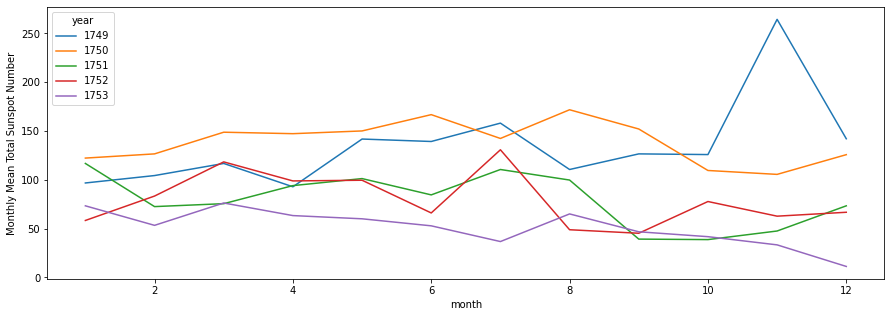

In [9]:
years = pv.columns[:5]
pv[years].plot()
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.show()

#### 3.2. Now, lets see how the time series look from 1749 to july 2018

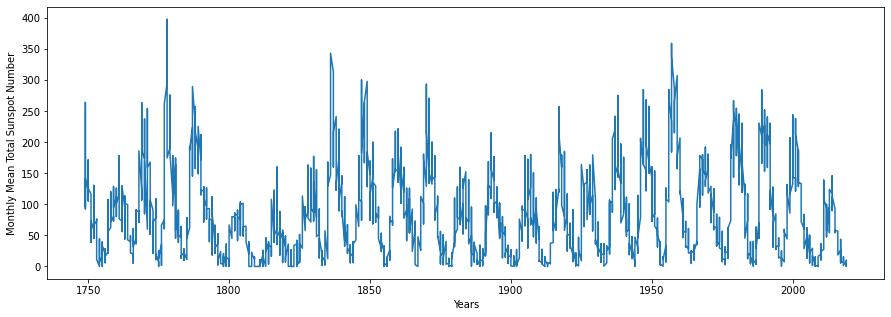

In [278]:
plt.plot(df['year'],df['Monthly Mean Total Sunspot Number'])
plt.xlabel('Years')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.show()

### 4. Data preparation 

#### 4.1. Now, we split the data into fix intervals with along with a prediction value.

In [46]:
years = 2 #hyperparameter
interval = 12*years 
X,y = [],[]
length = 3234
values = np.expand_dims(np.array(df['Monthly Mean Total Sunspot Number']),1)
for i in range (length):
    if i+interval < length:
        X.append(values[i:i+interval])
        y.append(values[i+interval])
X,y = np.array(X),np.array(y)

#### 4.2. we will now split our dataset into training and validation set.

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5. Building the LSTM model

#### 5.1. building the model with different hyperparamters

##### 5.1.1. Set the hyperparameters

In [75]:
#hyperparameters
units = 32
epochs = 50
batch_size = 32
learning_rate = 0.0001

#activation function
activation = 'relu'

#optimizer
optimizer = Adam(learning_rate=learning_rate)

#loss function
loss = Huber()#'mse'

#### 5.2. Build the model using keras

In [76]:
model = Sequential(name = 'sunspot_model')
model.add(Input(shape = (interval,1)))
model.add((LSTM(units, return_sequences = True,activation = activation,name = 'LSTM_1')))
model.add(LSTM(units, return_sequences = False,activation = activation,name = 'LSTM_2'))
model.add(Dense(units//2,  activation = activation))
model.add(Dense(units//4,  activation = activation))
model.add(Dense(1,  activation = activation, name = 'Output'))
model.compile(loss = loss, optimizer=optimizer,metrics = ['mae'])
model.summary()

Model: "sunspot_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 24, 32)            4352      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
Output (Dense)               (None, 1)                 9         
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________


#### 5.3. Training the model

In [77]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_split=0.1)

Epoch 1/50
73/73 - 3s - loss: 77.7446 - mae: 78.2347 - val_loss: 65.1470 - val_mae: 65.6396
Epoch 2/50
73/73 - 3s - loss: 62.7107 - mae: 63.2032 - val_loss: 53.5410 - val_mae: 54.0323
Epoch 3/50
73/73 - 3s - loss: 53.5891 - mae: 54.0821 - val_loss: 48.4665 - val_mae: 48.9596
Epoch 4/50
73/73 - 3s - loss: 51.0500 - mae: 51.5438 - val_loss: 49.6795 - val_mae: 50.1733
Epoch 5/50
73/73 - 2s - loss: 50.9784 - mae: 51.4728 - val_loss: 45.5841 - val_mae: 46.0800
Epoch 6/50
73/73 - 2s - loss: 47.2197 - mae: 47.7153 - val_loss: 39.5578 - val_mae: 40.0503
Epoch 7/50
73/73 - 2s - loss: 39.6677 - mae: 40.1631 - val_loss: 31.7817 - val_mae: 32.2770
Epoch 8/50
73/73 - 2s - loss: 34.5120 - mae: 35.0068 - val_loss: 29.5263 - val_mae: 30.0229
Epoch 9/50
73/73 - 2s - loss: 50.7551 - mae: 51.2507 - val_loss: 31.3441 - val_mae: 31.8399
Epoch 10/50
73/73 - 3s - loss: 29.3589 - mae: 29.8545 - val_loss: 27.5442 - val_mae: 28.0419
Epoch 11/50
73/73 - 4s - loss: 27.6482 - mae: 28.1435 - val_loss: 27.4407 - val

#### 5.4. Plot training and validation loss 

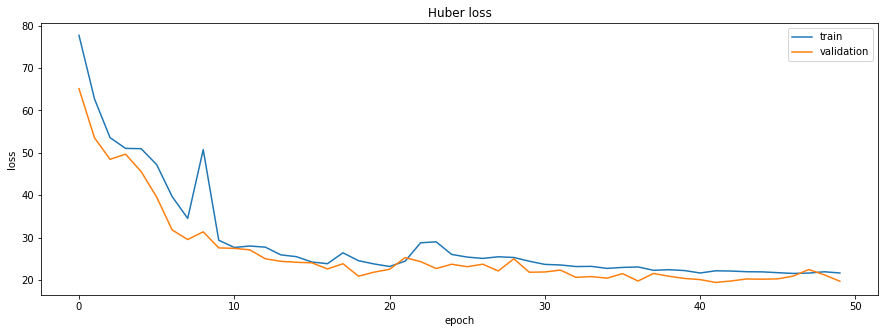

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Huber loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#### 5.5. Plot training and validation loss 

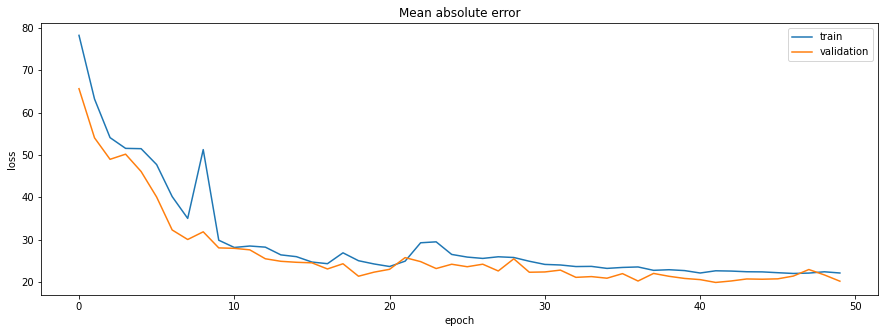

In [79]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean absolute error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### 6. Testing and Evaluation of the model

#### 6.1. Prediction on test data

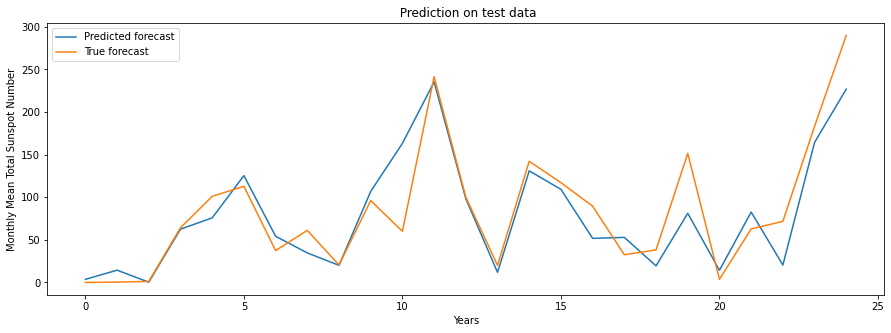

In [83]:
end = 25
prediction = model.predict(X_test)
plt.plot(prediction[:end], label='Predicted forecast')
plt.plot(y_test[:end,:], label = 'True forecast')
plt.title(' Prediction on test data')
plt.xlabel('Years')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

#### 6.2. Mean absolute error on test set

In [91]:
mean_absolute_error(y_test.ravel(), prediction.ravel())

21.237324170633638

#### 6.3. Prediction from Aug 2018 to Dec 2019

In [39]:
test = np.array(df['Monthly Mean Total Sunspot Number'][-19:])
test_years = np.array(df['year'][-19:])
test = values[-19:,:]

In [44]:
history = tf.convert_to_tensor(np.expand_dims(X[-1],0))
prediction_list = []
for i in range(len(test)):
    prediction = model.predict(history)
    prediction_list.append(prediction.ravel())
    prediction = np.expand_dims(prediction,0)
    history = np.delete(history, (0), axis=1)
    history = np.append(history, prediction,axis= 1)

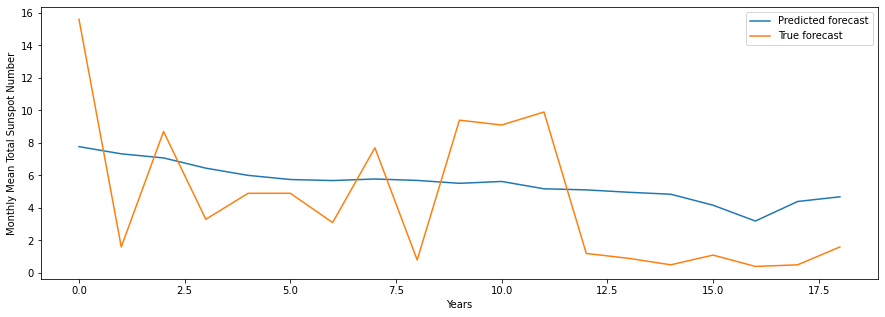

In [45]:
plt.plot(prediction_list, label='Predicted forecast')
plt.plot(test, label = 'True forecast')
plt.title('Prediction from Aug 2018 to Dec 2019')
plt.xlabel('Years')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

### 7. Conclusion